# Example codes: exact diagonalization
Please look at the [readme page](https://www.tensors.net/code) if you have not done so already. Here, we present an implementation of exact diagonalization for a quantum many-body Hamiltonian composed of a sum of local terms. This code formats the quantum problem in such a way that it can be passed as an input to a standard sparse eigensolver, which then performs the **exact diagonalization** based on the Lanczos algorithm. Important, however, is that we never form the full Hamiltonian $H$ as a matrix; instead the Hamiltonian is represented as a function that acts on an input state |ψ> in order to output $H$|ψ>. If we have a lattice of $N$ sites of local dimension $d$, then the memory required using this approach scales as O($d^N$), i.e. the memory required to represent a state |ψ>, as opposed to scaling as O($d^{(2N)}$), which would otherwise be required to represent $H$ as a matrix. This implementation can comfortably handle chains of $N = 25$ or more spin-1/2 sites when run on standard desktop / laptop PC's.


#### Summary

- Scaling of memory: O($d^N$)

- Implemented for a finite chain with open or periodic boundaries

- Uses the Lanczos algorithm built into the standard 'eigs' function

## Exact diagonalization tutorial


The goal of this code to is to find low-energy eigenstates of a Hamiltonian $H$, that is composed as a sum of local couplings `h`. In order to do this efficiently, we first write a function that computes $H$|Ψ> for an input quantum state |Ψ>, by applying each of the `h` couplings singularly. This function can then be passed to a standard sparse eigensolver such as **`eigs`**.

applying the local couplings `h` to the state is most easily accomplished by using a [tensordot](https://numpy.org/doc/stable/reference/generated/numpy.tensordot.html) function. This is built-in with numpy, and we provide custom versions for MATLAB and Julia.

the index ordering conventions for the state and the Hamiltonian are presented below.

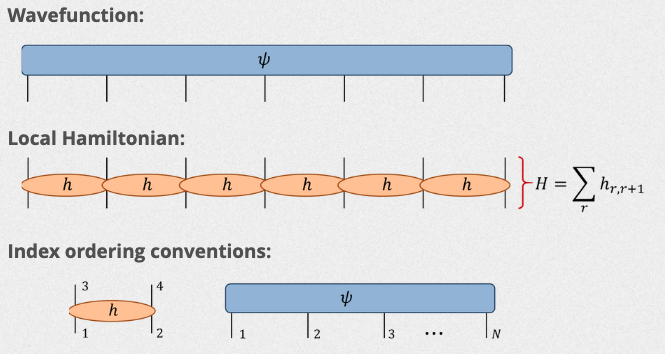


## Function for applying the Hamiltonian

Applies local Hamiltonian, given as sum of nearest neighbor terms, to an input quantum state.
#### Args:
- **psiIn** : vector of length $d^N$ describing the quantum state.
    
- **hloc** : array of $n_{dim}=4$ describing the nearest neighbor coupling.
    
- **$N$** : the number of lattice sites.
- **usePBC** : sets whether to include periodic boundary term.

#### Returns:
- **np.ndarray** : state psi after application of the Hamiltonian.

In [3]:
# doApplyHam.py
# ---------------------------------------------------------------------
# Routine used in the implementation of exact diagonalization.
#
# by Glen Evenbly (c) for www.tensors.net, (v1.2) - last modified 6/2019

import numpy as np
def doApplyHam(psiIn: np.ndarray, hloc: np.ndarray, N: int, usePBC: bool):
    d = hloc.shape[0]
    psiOut = np.zeros(psiIn.size)
    for k in range(N - 1):
    # apply local Hamiltonian terms to sites [k,k+1]
        psiOut += np.tensordot(hloc.reshape(d**2, d**2),
                           psiIn.reshape(d**k, d**2, d**(N - 2 - k)),
                           axes=[[1], [1]]).transpose(1, 0, 2).reshape(d**N)

    if usePBC:
    # apply periodic term
        psiOut += np.tensordot(hloc.reshape(d, d, d, d),
                           psiIn.reshape(d, d**(N - 2), d),
                           axes=[[2, 3], [2, 0]]
                           ).transpose(1, 2, 0).reshape(d**N)

    return psiOut

In [5]:
"""
mainExactDiag.py
---------------------------------------------------------------------
Script file for initializing exact diagonalization using the 'eigsh' routine
for a 1D quantum system.

by Glen Evenbly (c) for www.tensors.net, (v1.2) - last modified 06/2020
"""

import numpy as np
from scipy.sparse.linalg import LinearOperator, eigsh
from timeit import default_timer as timer

# from doApplyHam import doApplyHam

# Simulation parameters
model = 'XX'  # select 'XX' model of 'ising' model
Nsites = 18  # number of lattice sites
usePBC = True  # use periodic or open boundaries
numval = 1  # number of eigenstates to compute

# Define Hamiltonian (quantum XX model)
d = 2  # local dimension
sX = np.array([[0, 1.0], [1.0, 0]])
sY = np.array([[0, -1.0j], [1.0j, 0]])
sZ = np.array([[1.0, 0], [0, -1.0]])
sI = np.array([[1.0, 0], [0, 1.0]])
if model == 'XX':
    hloc = (np.real(np.kron(sX, sX) + np.kron(sY, sY))).reshape(2, 2, 2, 2)
    EnExact = -4 / np.sin(np.pi / Nsites)  # Note: only for PBC
elif model == 'ising':
    hloc = (-np.kron(sX, sX) + 0.5 * np.kron(sZ, sI) + 0.5 * np.kron(sI, sZ)).reshape(2, 2, 2, 2)
    EnExact = -2 / np.sin(np.pi / (2 * Nsites))  # Note: only for PBC


# cast the Hamiltonian 'H' as a linear operator
def doApplyHamClosed(psiIn):
      return doApplyHam(psiIn, hloc, Nsites, usePBC)


In [6]:
H = LinearOperator((2**Nsites, 2**Nsites), matvec=doApplyHamClosed)

# do the exact diag
start_time = timer()
Energy, psi = eigsh(H, k=numval, which='SA')
diag_time = timer() - start_time

# check with exact energy
EnErr = Energy[0] - EnExact  # should equal to zero

print('NumSites: %d, Time: %1.2f, Energy: %e, EnErr: %e' %
      (Nsites, diag_time, Energy[0], EnErr))

NumSites: 18, Time: 3.34, Energy: -2.303508e+01, EnErr: -2.842171e-14
